In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *

In [2]:
#Importación de librerías

#!pip install qiskit ipywidgets    correr esta línea de primero si se trabaja en google collab
#Importación de qiskit
from qiskit import *

%matplotlib inline
from matplotlib import *

#Se importa quantum_info para poder trabajar con herramientas útiles como las matríces de pauli y elementos para trabajar
# con operadores.
import qiskit.quantum_info as qi
from qiskit.quantum_info import *

#Simplemente para que no se vean los warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#Librerías matemáticas importantes
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
qi.Pauli('XXI').to_matrix()

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

# Energía para el modelo de Ising

El Hamiltoniano que describe al modelo de Ising se puede ver mediante la siguiente ecuación
$$ H = \sum_i^n \sigma_i^z \sigma_{i+1}^z+  g \sum_i^{n+1} \sigma_i^x   .$$

Entonces, es posible encontrar el valor promedio del hamiltoniano de la forma
$$  < \psi| H | \psi> = \sum_i^n <\psi|\sigma_i^z \sigma_{i+1}^z|\psi>  + g\sum_i^{n+1}<\psi| \sigma_i^x |\psi> $$

que es el nivel de energía correspondiente a esa función de onda $| \psi >$

El siguiente código busca esa implementación

In [4]:
def energia_ising(qubits,statevec,g):
    """  Energia para el Hamiltoniano del modelo de Ising para una función de onda:
    
         Esta función calcula la energía o valor promedio del Hamiltoniano perteneciente al 
         modelo de Ising para una función de estado otorgada y una constante g también 
         arbitraria. 
    
    Entrada(s): 
        statevec: vector de estado correspondiente a n-qubits que se están tratando. 
        g= constante real entera g como parte del Hamiltoniano
    
    """
    energia=0
    
    #Se itera por cada qubit hasta n-1 (sumatoria en sigmaz sigmaz+1)
    for i in range(0,qubits-1):
        
        parop=['','','']                   
        
        #Iteración sobre cada i-ésimo agregando la Identidad en el producto tensorial para la sumatoria de sigmaz,sigmax
        for j in range(0,i):
            parop[0]= parop[0] + 'I'
            parop[1]= parop[1] + 'I'

        #Se agrega ZZ como X en cada iteración
        parop[0] = parop[0] + 'ZZ'
        parop[1] = parop[1] + 'X'

        
        #Se agrega el tensor con la identidad para completar la dimensión del esatdo
        for w in range(i+2,qubits):
            parop[0] = parop[0]+'I'
        for q in range(i+1,qubits):
            parop[1] = parop[1]+'I'
            
            
        #Se encuentra el valor de energía para la i-ésima iteración, se suma al valor anterior
        energia= energia + np.matmul( statevec,  np.matmul(qi.Pauli(parop[0]).to_matrix() , statevec) ) + g*np.matmul(statevec, np.matmul(qi.Pauli(parop[1]).to_matrix() , statevec) )
        
        #Ya que la sumatoria recorre la de sigmaz, falta agregar un último término de sigmax,aquí se agrega
        if i==qubits-2:
            for k in range(0,i+1):
                parop[2]= parop[2] + 'I'
            parop[2]= parop[2]+ 'X'
            energia = energia + g*np.matmul(statevec, np.matmul(qi.Pauli(parop[2]).to_matrix(),statevec) ) #Se suma a la función de costo
        
          #Debugging
#         print(parop[0],parop[1],parop[2])  
#         print(energia)
        
    return energia

In [5]:
#Si por ejeemplo se tiene un estado que representa a 2 qubits (este caso no esta normalizado, tomarlo en cuenta)
#el código nos regresará su energía correspondiente
statevec=np.array([1,2,3,4])
energia_ising(2,statevec,2)

(104+0j)

## Autovalores teóricos
Tomando como esqueleto el código anterior, es posible crear el hamiltoniano y extraerle su autovalor mínimo. Con esto podemos comparar la energía encontrada con cada statevector y ver que tanto se acerca a la parte teórica. 

El código es el siguiente:

In [6]:
def H_teo(qubits,g):
    """  Energia mínima para el Hamiltoniano de Ising:
    
         Esta función calcula el valor de energía mínima del Hamiltoniano de Ising para 
         un número dado de qubits y valor de constante g. 
         
    Entrada(s): 
        qubits: número de qubits en el modelo de Ising. 
        g= constante real entera g como parte del Hamiltoniano
    
    """
    H=0
    
    #Se itera por cada qubit hasta n-1 (sumatoria en sigmaz sigmaz+1)
    for i in range(0,qubits-1):
        
        parop=['','','']                   
        
        #Iteración sobre cada i-ésimo agregando la Identidad en el producto tensorial para la sumatoria de sigmaz,sigmax
        for j in range(0,i):
            parop[0]= parop[0] + 'I'
            parop[1]= parop[1] + 'I'

        #Se agrega ZZ como X en cada iteración
        parop[0] = parop[0] + 'ZZ'
        parop[1] = parop[1] + 'X'

        
        #Se agrega el tensor con la identidad para completar la dimensión del esatdo
        for w in range(i+2,qubits):
            parop[0] = parop[0]+'I'
        for q in range(i+1,qubits):
            parop[1] = parop[1]+'I'
            
            
        #Se genera el hamiltoniano en base a los operadores anteriores
        H= H + qi.Pauli(parop[0]).to_matrix() + g*qi.Pauli(parop[1]).to_matrix() 
        
        #Ya que la sumatoria recorre la de sigmaz, falta agregar un último término de sigmax,aquí se agrega
        if i==qubits-2:
            for k in range(0,i+1):
                parop[2]= parop[2] + 'I'
            parop[2]= parop[2]+ 'X'
            H = H + g*qi.Pauli(parop[2]).to_matrix() #Se suma el último qubit restante para este código. 
        
    H= np.amin(np.linalg.eig(H.real)[0]) #Se tooma el autovalor mínimo, correspondiente al valor mínimo de energía
        
    return H


# Generador de circuitos para n qubits

Definiremos los parámetros theta que son interpretados como rotaciones en un circuito en el eje y, estos caracterizan por un vector $\vec{\theta}$, por lo que nuestro circuito dependerá de ese parámtetro. El código siguiente busca esa implementación

In [7]:
def circ_nqubits(qubits,capas,parametros):
  """ Circuito para modelo de Ising:
  
      La función circ_nqubits genera un circuito para un número n de qubits
      con un número n de capas que el usuario desee implementar. Para esto es necesaria
      una matriz con los parámetros theta de dimensión  qubits x capas. 
      
  Entrada(s):
      qubits: el número de qubits a analizar. 
      capas: el número de capas para el ansatz del circuito. 
      parámetros: vector de dimension capasxparametros conteniendo rotaciones.  
  
  Salida(s): 
      circ: objeto de tipo QuantumCircuit conteniendo las instrucciones del circuito cuántico para IBM, como Qiskit.
      Statevector: vector de estado resultante del circuito.  
  
  
  """
  parametros = np.transpose(np.reshape(parametros,(capas,qubits)))  #Se escribe nuestro vector de parámetros como una matriz. 
  circ=QuantumCircuit(qubits)              #Inicilización del circuito
  
 
  capflag=True                             #Condición inicial de la bandera de cada capa

  for i in range(0,capas):
        
        flag1=True                         #Condiciones iniciales de las banderas para los cx
        flag2=False
        
        
        #Rotaciones parametrizadas al inicio de la capa
        for j in range(0,qubits):
             circ.ry(parametros[j][i],[j]) #Se aplica una rotación de las componentes de la matríz 
        
        
        #Revisión para la capa con bandera verdadera
        if capflag==True:
            #Se aplicará la cX a cada par de qubits, dejando uno como espacio. 
            for j in range(0,qubits-1):
                  if flag1==True: 
                    circ.cx([j],[j+1])     #Aplica la cX entre los 2 próximos
                    flag1=False            #Baja la bandera, así en la proxima iteración osalta el j+1

         #Salto de un qubit para el cx           
                  elif flag1==False:
                    flag1=True             #Sube la bandera para que en la siguiente si se aplique el cX 
            capflag=False                  #Se baja la bandera de la capa para que se use el cx entre los restantes
         
        #Revisión para la capa con bandera falsa (cx para unitr los qubits)
        elif capflag==False:
            #Se aplicará cx hacia los pares de qubits que todavía no se han conectado
            for w in range(0,qubits-1):
                if flag2==True:
                    circ.cx([w],[w+1])     #Aplica cx entre los 2 próximos al igual que la anterior
                    flag2=False            #Baja la bandera, en la próxima iteración saltará la cx entre esos qubits
                    
                elif flag2==False:
                    flag2=True             #Se sube la bandera para que no se aplique
                   
            capflag=True                   #Se retorna la bandera de la capa como verdadera nuevamente
            
           
  #Extraemos el statevector del circuito directamente     
  statevec=Statevector.from_instruction(circ).__array__()
#   return statevec
  return statevec,circ     #descomentar esta línea si se quiere retornar el circuito, dejarla comentada para la optimización 
                             # y procesos posteriores. 
    

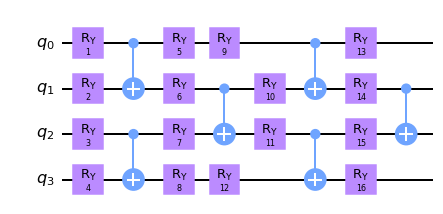

In [8]:
#Como ejemplo para este circuito se tienen ciertos parametros para 3 qubits con 2 capas
parametros=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

a,b=circ_nqubits(4,4,parametros) #Para desplegar el circuito, descomentar la linea marcada en la función anterior
b.draw()


# Función de costo

La función de costo busca analizar el comportamiento de los valores de energía para los parámetros $\vec \theta$ que se estén pasando. 

$$ C(\theta) = < \psi(\theta)| H | \psi (\theta) > .$$

Su implementación será la unión de las dos implementaciones, siendo entonces

In [9]:
#Función de costo
    
#Condiciones iniciales para la función 
qubits=6   #Se designa el número de qubits
g=-0.2 #Se mira el valor de g
capas=4    #Se establece el número de capas
cost_por_iteracion=[]

def cost_function(parametros):
    #Se ejecutan las dos funciones anteriores y se obtiene el valor de la función de
    # costo para este valor. 
    statevec=circ_nqubits(qubits,capas,parametros)
    
    # Calculamos la funcion de costo para ese set de parametros
    cost_value=energia_ising(qubits,statevec,g)
    cost_por_iteracion.append(cost_value.real)
    return(cost_value.real)

## Proceso de Optimización

Para la optimización de la función de costo podemos minimzar aún más los valores de energía, siempre buscando obtener el valor mínimo para cada circuito con el número de capas fijo

In [10]:
import scipy


'''Proceso de optimización:
Para optimizar en este segmento se procederá a utilizar scipy.optimize.minimize(), procurando que en cada iteración
el valor de los parámetros "parame2", quien son los ángulos sean los valores obtenidos con el método optimize siempre
y cuándo el valor actual sea menor al anterior (minimizar el valor de mínima energía)'''


#Condiciones iniciales movibles:

qubits=4   #Se designa el número de qubits
g=-0.2 #Se mira el valor de g
capas=10    #Se establece el número de capas
cost_por_iteracion=[]
maxitr=300


parame2=np.random.rand(qubits*capas,1)*2*np.pi
results = scipy.optimize.minimize(cost_function,parame2,method='COBYLA',options={'maxiter':maxitr,'disp': False}) 
cost_anterior=cost_por_iteracion
parame2=results.x

# #Iteraciones con minimización 
for i in range(1,10):
#     print(len(cost_anterior))   #Debugging
    cost_por_iteracion=[]
    results = scipy.optimize.minimize(cost_function,parame2,method='COBYLA',options={'maxiter':maxitr,'disp': False}) 
    if cost_anterior[maxitr-1] > cost_por_iteracion[maxitr-1]:
        print(cost_anterior[maxitr-1])
        cost_anterior=cost_por_iteracion   
        parame2=results.x 

Traceback (most recent call last):
  File "/tmp/ipykernel_79/2414427078.py", line 20, in <module>
    results = scipy.optimize.minimize(cost_function,parame2,method='COBYLA',options={'maxiter':maxitr,'disp': False})
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/_minimize.py", line 629, in minimize
    return _minimize_cobyla(fun, x0, args, constraints, **options)
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/cobyla.py", line 34, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/cobyla.py", line 260, in _minimize_cobyla
    xopt, info = _cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/cobyla.py", line 252, in calcfc
    f = fun(np.copy(x), *args)
  File "/tmp/ipykernel_79/1898739949.py", line 15, in cost_function
    cost_value=energia_ising(qubits,statevec,g)
  File "/tmp/ipykernel_79/3754251941.py", line 38, in energia_ising
 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Es entonces que podemos observar como nuestra energía converge al valor teórico al optimizar los parámetros $\vec{\theta}$. 

In [11]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(8, 5))
plt.plot(cost_anterior,'g')
plt.xlabel("Iteración",size=10)
plt.ylabel("Energía Mínima ",size=10)
# plt.xscale("log")

plt.axhline(y=H_teo(qubits,g), color='r', linestyle='-')
plt.tight_layout()
plt.grid()
# fig.show()
# cost_por_iteracion

Traceback (most recent call last):
  File "/tmp/ipykernel_79/3344147676.py", line 4, in <module>
    plt.plot(cost_anterior,'g')
NameError: name 'cost_anterior' is not defined

Use %tb to get the full traceback.


<Figure size 576x360 with 0 Axes>

In [12]:
print( float("{0:.5f}".format(H_teo(4,-0.2))))
print(float("{0:.5f}".format(cost_anterior[maxitr-1])))
plt.plot([ float("{0:.2f}".format(H_teo(4,-0.2))) , float("{0:.2f}".format(cost_anterior[maxitr-1]))] , [1,2],'r*')

-3.06173
Traceback (most recent call last):
  File "/tmp/ipykernel_79/970679616.py", line 2, in <module>
    print(float("{0:.5f}".format(cost_anterior[maxitr-1])))
NameError: name 'cost_anterior' is not defined

Use %tb to get the full traceback.


## Extracción de un dataset

Ahora podemos extraer un dataset generando valores 'g' aleatorios de rango 0 a 1 y de rango 1 a 2 de tal forma que tengamos un dataset con el que podamos entrenar nuestra red neuronal. Para ello , usamos el siguiente código.

In [12]:
def extra_dataset(num,rango,ges=None,params=None):
    """
        Función designada para la extracción del dataset para el entrenamiento de la red neuronal. 
        
        Entrada(s):
        num: número de datos a extraer 
        rango: rango de datos para g. 0 --> [0,1] , 1--> [1,2]. Si este dato no se llena entonces
               el número por defecto será 0. 
        ges: nombre del archivo de texto conteniendo los valores de g generados. Este parámetro debe ser del tipo string '' 
        params: nombre del archivo de texto conteniendo los parámetros theta usados para generar el circuito 
                optimizado. Este parámetro debe ser del tipo string ' '
        
        Salida(s):
        Dos archivos de texto: 
        1. ges.txt (o el nombre que se le asigne a la variable ges): archivo de texto con valores de g generados. 
        2. params.txt (o el nombre que se le asigne a la variable params): archivo de texto con valores de los parámetros
                                                                           theta guardados de todas las iteraciones. 
    
    """
    #Condición de parámetros de archivos nulos. 
    if params==None:
        params="params.txt"
    else:
        params=params+".txt"
        
    if ges==None:
        ges="ges.txt"
    else:
        ges=ges+".txt"
       
    #Apertura de archivos de texto
    f1 = open(ges, "w")
    f2 = open(params,"w")
    
    #Proceso de guardado en archivo
    for i in range(0,num):
        
        #Condiciones iniciales por iteración de optimización
        cost_por_iteracion=[]
        parame2=np.random.rand(qubits*capas,1)*2*np.pi
        maxitr=300                #Número máximo de iteraciones en optimize
        
        #Condición inicial para g. 
        if rango==None:
            g=np.random.uniform()
        elif rango==0:
            g=np.random.uniform()
        elif rango==1:
            g=np.random.uniform()+1

        results = scipy.optimize.minimize(cost_function,parame2,method='COBYLA',options={'maxiter':maxitr,'disp': False}) 

        #Escritura en los archivos de texto
        f1.write(str(float("{0:.10f}".format(g))))  #Redacción de parámetros g en el primer archivo de texto
        f1.write("\n")
        
        with open(params, "ab") as f:        #Escritura de parámetros theta en el segundo archivo de texto
            numpy.savetxt(f, parame2)

    f1.close()
    f2.close()

In [150]:
#Extracción del dataset: 

#Condiciones iniciales 
qubits=6  
capas=12  
num=3
extra_dataset(num,0,'ges0','params0')

Traceback (most recent call last):
  File "/tmp/ipykernel_60/2416349396.py", line 6, in <module>
    extra_dataset(3,0,'ges0','params0')
NameError: name 'extra_dataset' is not defined

Use %tb to get the full traceback.


Los datos entonces pueden ser leídos y trabajados con el código:

In [153]:
ges=np.loadtxt("ges0.txt")
paramsfull=np.loadtxt("params0.txt")
paramsfull=np.reshape(paramsfull,(num,qubits*capas))

In [157]:
costos=[]
for i in range(0,num):
    costos.append(cost_function(paramsfull[i]))

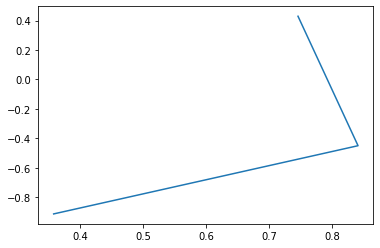

In [159]:
plt.plot(ges,costos)

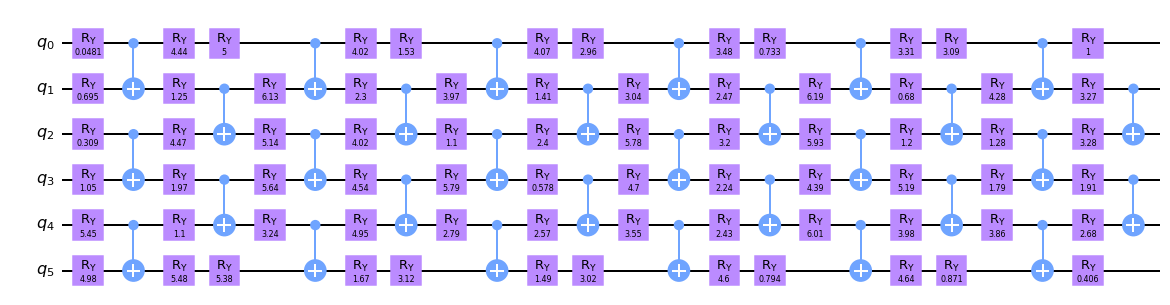

In [200]:
a,b=circ_nqubits(6,12,paramsfull[2])
b.draw()

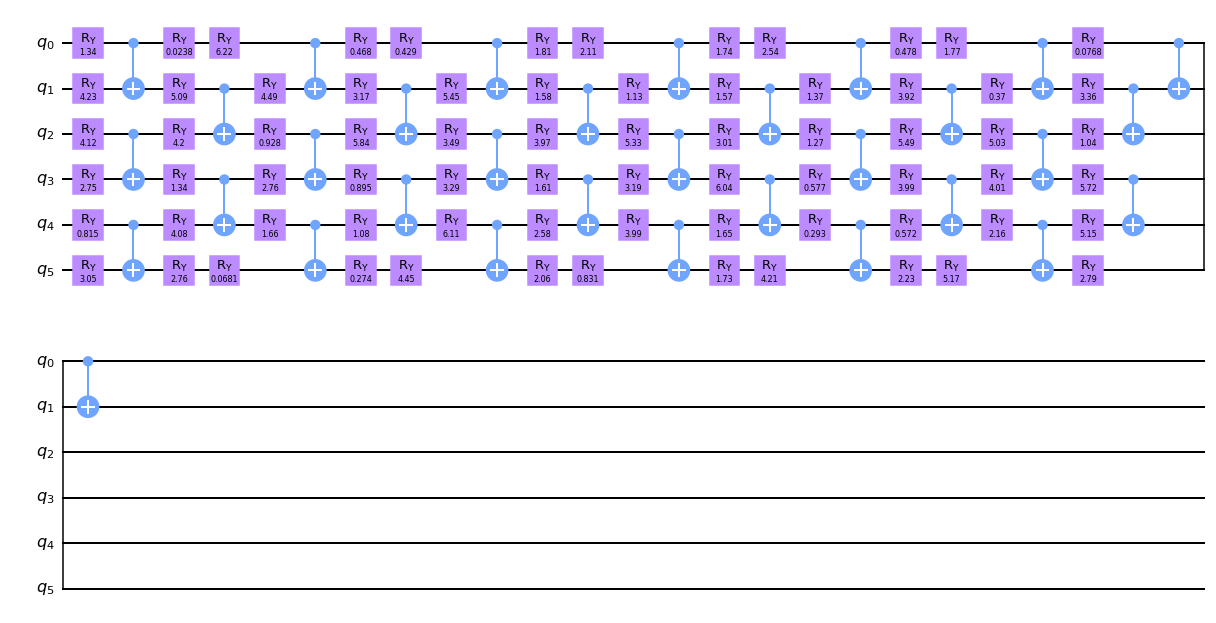

In [198]:
b.cx(0,1)
b.draw()